<h2 align="center">2D/3D Pattern stitching</h2>

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.misc import imresize
from scipy.ndimage import gaussian_filter
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import matplotlib.image as image
from stl import base,mesh
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



We assume that the patterns that need to be stitched together are laid out symmetrically and a right end to left end join
to complete the stitching pattern. We also assume that the cut points are user defined and are known and that the patterns are to be combined starting from the left.

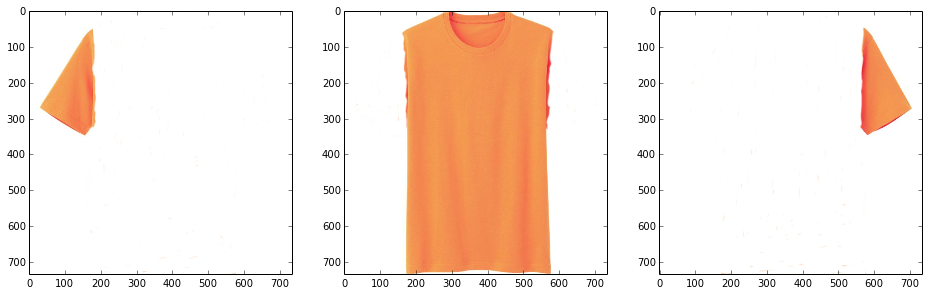

In [3]:
from stl_tools import numpy2stl

dataFolder="/am207/project/data/"
inputFolder = "/am207/project/input/"
plt.figure(figsize=(16,8))
plt.subplot(131)
img1 = image.imread(inputFolder+"left_orange.jpeg")
plt.imshow(img1)
plt.subplot(132)
img2 = image.imread(inputFolder+"front_orange.jpeg")
plt.imshow(img2)
plt.subplot(133)
img3 = image.imread(inputFolder+"right_orange.jpeg")
plt.imshow(img3)

In [4]:
def combine_l(img1,cut1,img2):
# assumes equal sized images
# cut points are specified as a list of 2D tuples
    n,m,l=img1.shape
    combined = np.zeros((n,m,l), 'uint8')
    for i in xrange(n):
        for j in xrange(m):
            include = False
            for k in xrange(len(cut1)):
                if i <= cut1[k][0] and j <= cut1[k][1]:
                    include=True
                    combined[i,j]=img1[i,j]
                else:                
                    combined[i,j]=img2[i,j]
            if include:                    
                combined[i,j]=img1[i,j]
            else:                
                combined[i,j]=img2[i,j]

    return combined
def combine_h(img1,cut1,img2):
# assumes equal sized images
# cut points are specified as a list of 2D tuples
    n,m,l=img1.shape
    combined = np.zeros((n,m,l), 'uint8')
    for i in xrange(n):
        for j in xrange(m):
            include = False
            for k in xrange(len(cut1)):
                if i > cut1[k][0] and j > cut1[k][1]:
                    include=True
            if include:
                combined[i,j]=img1[i,j]
            else:                
                combined[i,j]=img2[i,j]
    return combined

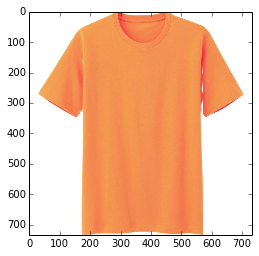

In [49]:
combined = combine_h(img3,[(50,570)], combine_l(img1,[(350,175)],img2) )
plt.imshow(combined)

In [50]:
xs = np.random.uniform(0,700,1000)
ys = np.random.uniform(0,700,1000)

In [53]:
triang = Delaunay(zip(xs,ys))

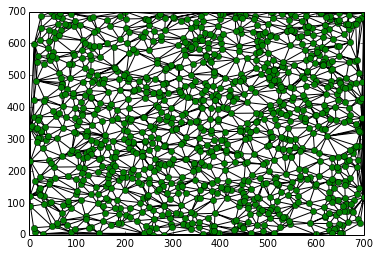

In [55]:
plt.triplot(xs,ys, triang.simplices.copy())
plt.plot(xs,ys, 'o')
plt.show()

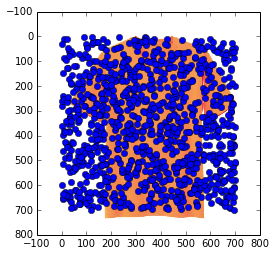

In [69]:
plt.imshow(combined)
plt.plot(ys,xs, 'o')

In [60]:
n,m,l=combined.shape
def pdf(pt_x,pt_y):
    #we just use one channel but this should generalize
    if combined[pt_x,pt_y,0] == 255:
        return 0.00001
    return np.log( (combined[pt_x,pt_y,0]-150)**2) # we use the distance from mean value of the channel

# Metropolis algorithm
def Metropolis(x0, y0, logf, N, burnin):
    x = np.zeros(N)
    y = np.zeros(N)
    xold = x0
    yold = y0
    r = np.random.random(N)
    count = 0
    for i in xrange(N):
        xnew = np.random.uniform(0,n)
        ynew = np.random.uniform(0,m)
        
        if np.log(r[i]) < logf(xnew, ynew) - logf(xold, yold):
            xold = xnew
            yold = ynew
            count += 1
        x[i] = xold
        y[i] = yold
    
    print "The acceptance rate is "+ str(float(count)/N)+"."
    return x[burnin:], y[burnin:]

In [61]:
x_mc,y_mc = Metropolis(350,350,pdf,10000,0)

The acceptance rate is 0.6126.


In [77]:
triang_mc = Delaunay(np.array([x_mc,y_mc]).T)

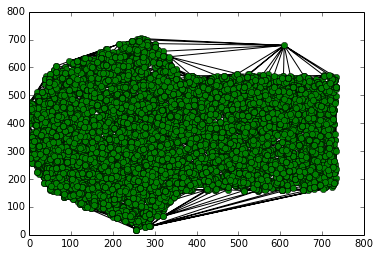

In [81]:
plt.triplot(x_mc,y_mc, triang_mc.simplices.copy())
plt.plot(x_mc,y_mc, 'o')
plt.show()

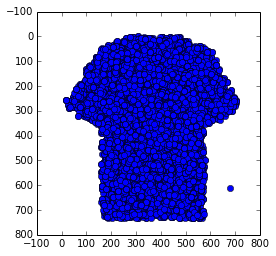

In [79]:
plt.imshow(combined)
plt.plot(y_mc,x_mc, 'o')

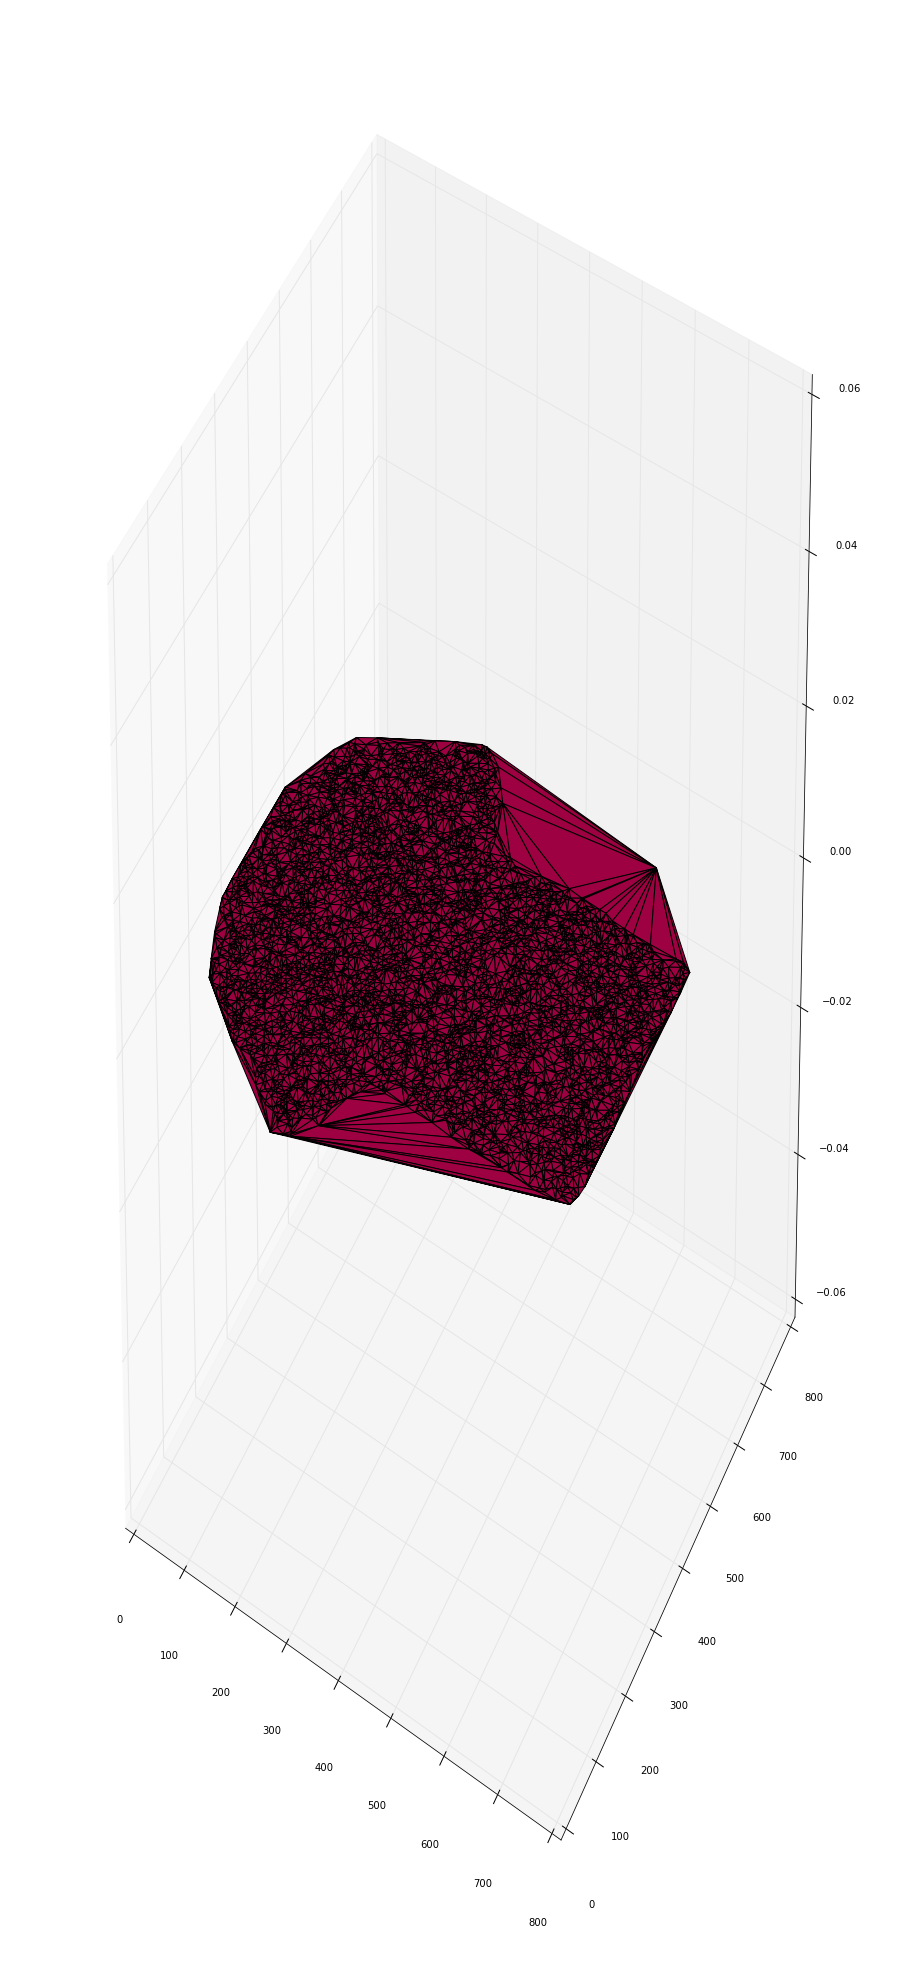

In [91]:
fig = plt.figure(figsize=(16,35))
ax = fig.gca(projection='3d')
z_mc = np.zeros(len(x_mc))
ax.plot_trisurf(x_mc, y_mc,z_mc, triangles=triang_mc.simplices, cmap=plt.cm.Spectral)